# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  71.75 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128 # 64
N = 80000 # 20000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 80000
Taking FFT of the images:
Batch 1/10  21.87 sec.
Batch 2/10  21.86 sec.
Batch 3/10  21.87 sec.
Batch 4/10  21.87 sec.
Batch 5/10  21.87 sec.
Batch 6/10  21.88 sec.
Batch 7/10  21.57 sec.
Batch 8/10  21.55 sec.
Batch 9/10  21.57 sec.
Batch 10/10  21.54 sec.
FFT done. Time:  269.13 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (80000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  20.96 sec.


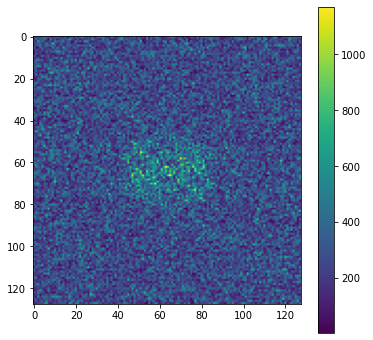

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [7]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different
* SGD seems to overfit at small batch size (e.g. 32) - better objective (??? maybe there's something wrong with how I calculate loss_epoch) but much worse FSC. Batch size = 1000 seems good for both methods, interestingly the OASIS FSC stays above 0.9 for all resolutions (up to 6.6 Angs for nx=128 -> maybe try a bit higher?).

In [8]:
sigma_noise_est = sigma_noise
sigma_noise = jnp.ones(sigma_noise.shape)
#sigma_noise = sigma_noise_est

In [9]:
sigma_noise

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)

In [10]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [11]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [72]:
alpha =  1e-5 #1e-9 # 1e-5

slice_obj = Slice(x_grid, mask = mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [73]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [74]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)


In [75]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

100%|██████████| 2000/2000 [03:05<00:00, 10.77it/s]


6.300183912601216e-06
0.021110114591760147
3350.7140243219055


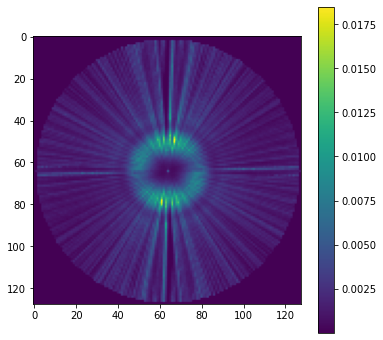

In [76]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

6.300183912601216e-06
0.021110114591760147


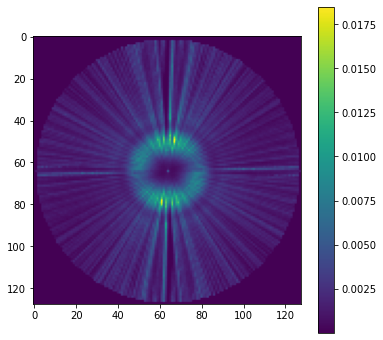

In [77]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [78]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

0.021110114591760147
0.02100215371071333
0.0016181175645230174


#### SGD

In [81]:
N_epochs = 10
batch_size = 1000
step_size =  1e1 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

# 10k imgs, 64px:
#   no sigma_noise, no precon: 1e1 V
#   no sigma_noise, with precon: 1e-2 V
#   with sigma_noise, no precon: 1e6 V
#   with sigma_noise, with precon: 1e-1 V

# 40k imgs, 128px , reg 1e-5
#  no sigma_noise, no precon: 1e1 V
#  no sigma_noise, with precon: 1e-4

# ======= not sure about the above step sizes

#  with sigma_noise, no precon: 1e5, 13 angs (1e6 is worse: 15 angs)
#  with_sigma_noise, with precon: 1e-3, 

In [82]:
P1 = None
#P1 = 1/D01

key, subkey = random.split(key)
x01 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 40/40 [00:34<00:00,  1.14it/s, grad=7.764e+00, loss=7.787e+08]


  |Grad| = 1.244e+01
  Loss = 7.794e+08
Epoch 2/10 

100%|██████████| 40/40 [00:34<00:00,  1.14it/s, grad=7.072e+00, loss=7.754e+08]


  |Grad| = 7.001e+00
  Loss = 7.765e+08
Epoch 3/10 

100%|██████████| 40/40 [00:34<00:00,  1.14it/s, grad=7.477e+00, loss=7.747e+08]


  |Grad| = 7.006e+00
  Loss = 7.761e+08
Epoch 4/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.400e+00, loss=7.790e+08]


  |Grad| = 6.795e+00
  Loss = 7.760e+08
Epoch 5/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.020e+00, loss=7.738e+08]


  |Grad| = 6.879e+00
  Loss = 7.759e+08
Epoch 6/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.728e+00, loss=7.752e+08]


  |Grad| = 6.955e+00
  Loss = 7.759e+08
Epoch 7/10 

100%|██████████| 40/40 [00:34<00:00,  1.14it/s, grad=6.283e+00, loss=7.793e+08]


  |Grad| = 7.035e+00
  Loss = 7.759e+08
Epoch 8/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.843e+00, loss=7.784e+08]


  |Grad| = 6.911e+00
  Loss = 7.759e+08
Epoch 9/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.461e+00, loss=7.747e+08]


  |Grad| = 7.046e+00
  Loss = 7.758e+08
Epoch 10/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.566e+00, loss=7.773e+08]

  |Grad| = 6.973e+00
  Loss = 7.758e+08


In [83]:
P2 = None
#P2 = 1/D02

key, subkey = random.split(key)
x02 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.079e+00, loss=7.771e+08]


  |Grad| = 1.246e+01
  Loss = 7.796e+08
Epoch 2/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.517e+00, loss=7.778e+08]


  |Grad| = 6.921e+00
  Loss = 7.766e+08
Epoch 3/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.266e+00, loss=7.739e+08]


  |Grad| = 6.946e+00
  Loss = 7.762e+08
Epoch 4/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.630e+00, loss=7.775e+08]


  |Grad| = 6.945e+00
  Loss = 7.761e+08
Epoch 5/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.238e+00, loss=7.771e+08]


  |Grad| = 6.648e+00
  Loss = 7.760e+08
Epoch 6/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.752e+00, loss=7.777e+08]


  |Grad| = 6.788e+00
  Loss = 7.760e+08
Epoch 7/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=8.336e+00, loss=7.788e+08]


  |Grad| = 6.866e+00
  Loss = 7.760e+08
Epoch 8/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.534e+00, loss=7.744e+08]


  |Grad| = 6.906e+00
  Loss = 7.760e+08
Epoch 9/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=6.831e+00, loss=7.723e+08]


  |Grad| = 6.922e+00
  Loss = 7.760e+08
Epoch 10/10 

100%|██████████| 40/40 [00:35<00:00,  1.14it/s, grad=7.618e+00, loss=7.762e+08]

  |Grad| = 6.935e+00
  Loss = 7.760e+08


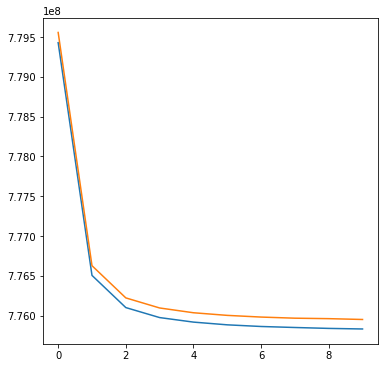

In [84]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)

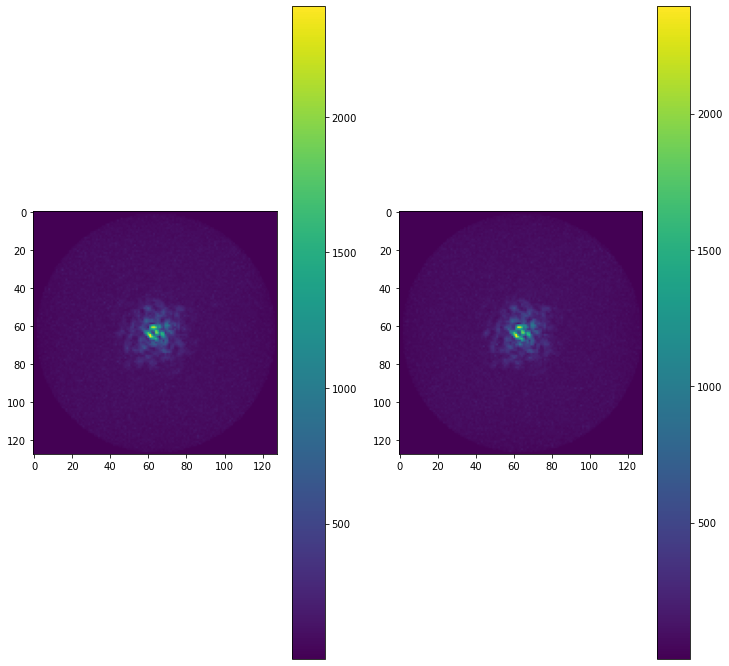

In [85]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec2))); plt.colorbar()

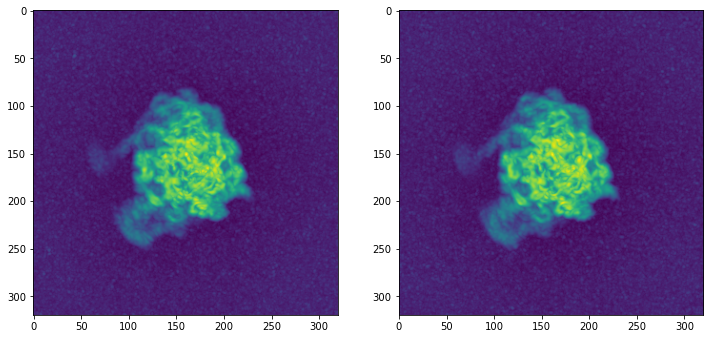

In [86]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [87]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

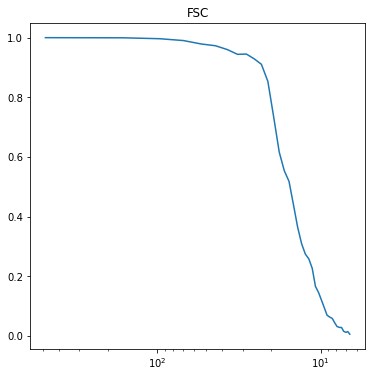

In [88]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [89]:
print(fsc_sgd[15])
print(fsc_sgd[16])
print(res_angs[15])
print(res_angs[16])

0.5178940384340327
0.43964158607554965
15.614531151244588
14.668195929957037


#### OASIS

In [96]:
N_epoch = 10 #30
beta2 = 0.99
eta0 = 1e-4 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-16 #0.1 # 0.01

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)


# Step sizes (eta0): 
#
# 10k imgs, 64px:
#   no sigma_noise: 1e-4 (1e-3 if beta2=1) V
#   with sigma_noise: 1e-4 V
#
# 40k imgs, 128px: reg 1e-5
#   no sigma_noise: 1e-4

##### not sure about the step sizes above

#   with sigma_noise: 1e-4, 9 angs;
#               1e-3: getting 7 angs, but the complex part goes up and so the loss goes up - weird. 
# I probably need to fix the handling of the complex part. And the FSC is low because I take the real
# part of the correlation. Think about this. Is it because the cmplex part is not handled properly?

In [97]:
key, subkey1, subkey2 = random.split(key, 3)
x01 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o1, loss_o1 = oasis(subkey2, loss_func1, grad_func1, hvp_func1, x01, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


[ 708329879 3133932367]
Epoch 1/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.992e+08]


  Loss =  7.973e+08
Epoch 2/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.994e+08]


  Loss =  7.972e+08
Epoch 3/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.944e+08]


  Loss =  7.971e+08
Epoch 4/10


100%|██████████| 40/40 [00:50<00:00,  1.26s/it, loss=7.945e+08]


  Loss =  7.970e+08
Epoch 5/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=8.020e+08]


  Loss =  7.970e+08
Epoch 6/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.991e+08]


  Loss =  7.969e+08
Epoch 7/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.949e+08]


  Loss =  7.969e+08
Epoch 8/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=8.010e+08]


  Loss =  7.969e+08
Epoch 9/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.988e+08]


  Loss =  7.968e+08
Epoch 10/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.966e+08]

  Loss =  7.968e+08


In [98]:
key, subkey1, subkey2 = random.split(key, 3)
x0 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)

#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey2, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [99]:
key, subkey1, subkey2 = random.split(key, 3)

x02 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o2, loss_o2 = oasis(subkey2, loss_func2, grad_func2, hvp_func2, x02, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


[844380340  16967902]
Epoch 1/10


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, loss=7.970e+08]


  Loss =  7.974e+08
Epoch 2/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.960e+08]


  Loss =  7.973e+08
Epoch 3/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.956e+08]


  Loss =  7.973e+08
Epoch 4/10


100%|██████████| 40/40 [00:50<00:00,  1.26s/it, loss=7.972e+08]


  Loss =  7.972e+08
Epoch 5/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.997e+08]


  Loss =  7.971e+08
Epoch 6/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=8.020e+08]


  Loss =  7.971e+08
Epoch 7/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.986e+08]


  Loss =  7.971e+08
Epoch 8/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.951e+08]


  Loss =  7.970e+08
Epoch 9/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.971e+08]


  Loss =  7.970e+08
Epoch 10/10


100%|██████████| 40/40 [00:50<00:00,  1.27s/it, loss=7.969e+08]

  Loss =  7.970e+08


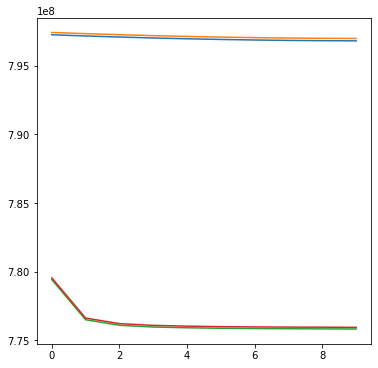

In [100]:
plt.plot(loss_o1)
plt.plot(loss_o2)
plt.plot(loss_rec1)
plt.plot(loss_rec2)


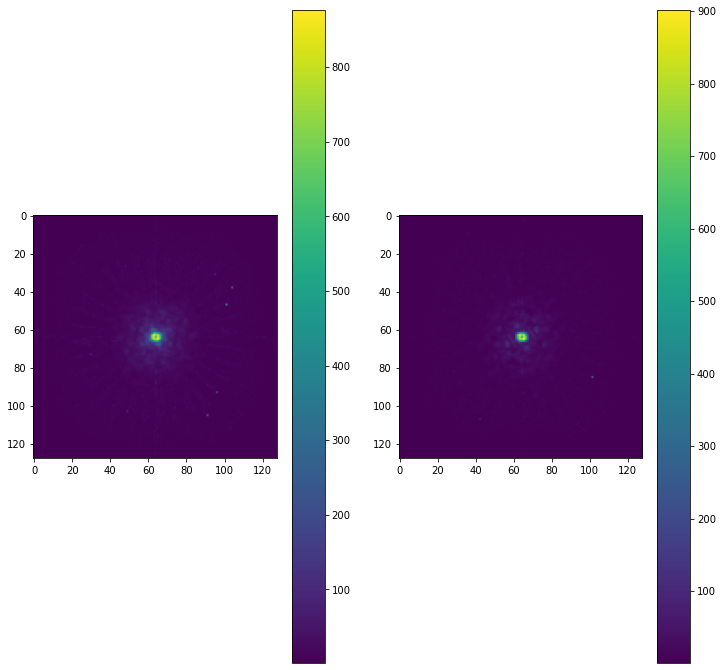

In [101]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.real(v_rec_o2))); plt.colorbar()

plt.rcParams["figure.figsize"]= 6, 6


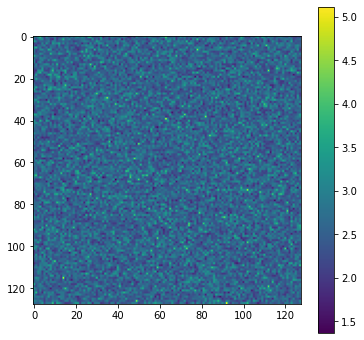

In [102]:
mip_z(np.imag(x01-x02)); plt.colorbar()

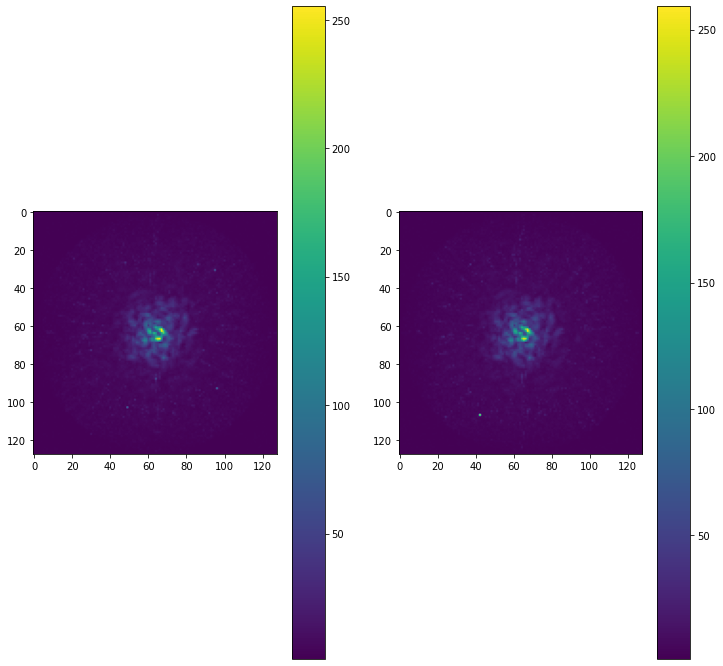

In [103]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec_o2))); plt.colorbar()

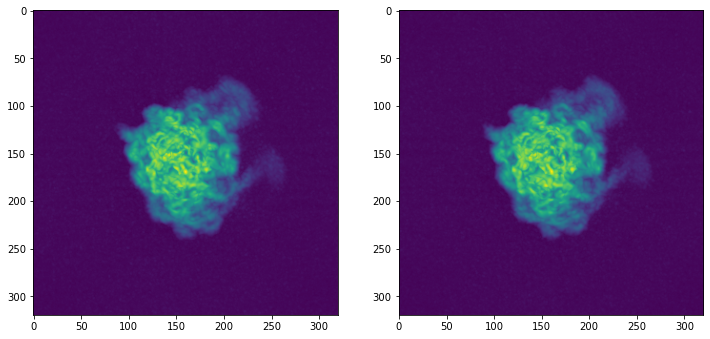

In [104]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [105]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

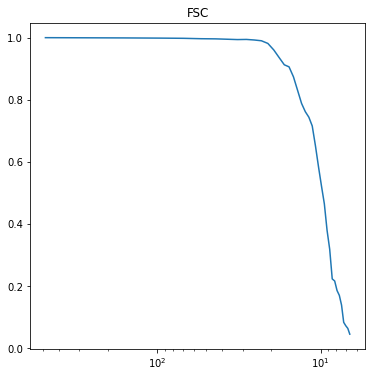

In [106]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

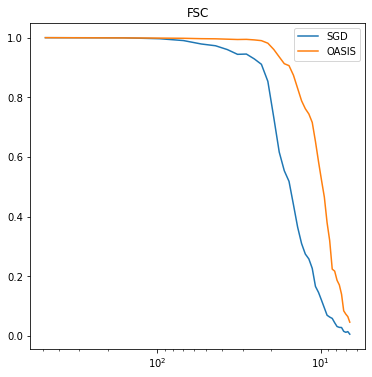

In [107]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [113]:
print(fsc_o[24])
print(fsc_o[25])
print(res_angs[24])
print(res_angs[25])

0.522040957360859
0.4653112403390909
9.87858093242005
9.49118560173691


In [ ]:
fsc_o

In [ ]:
res_angs

In [ ]:
#Nn = N//2

In [ ]:
#loss_func1(v_rec1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
#loss_func1(v_rec_o1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec_o2, jnp.arange(Nn))

#### Now the same with CG

In [ ]:
N_iter = 300


In [ ]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [ ]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg1, _ = cg(AA1, Ab1, x0, N_iter, verbose=True)

In [ ]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg2, _ = cg(AA2, Ab2, x0, N_iter, verbose=True)

In [ ]:
Nn=N//2

In [ ]:
loss_func1(v_rec_cg1, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_o2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

In [ ]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

In [ ]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
fsc_cg

In [ ]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

In [ ]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning).
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

# I think I need to re-run all the experiments below, and carefully choose the learning rate/step size, all at 30 epochs and with SEPARATE randomly initialized x0 and random seeds (for OASIS)

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 30 epochs (for SGD/OASIS) and 300 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

no $\sigma_{noise}$:
* SGD no precon: $\approx 20 Å$ V
* SGD with precon:  $\approx 20 Å$ V
* OASIS: $FSC \geq 0.6$, V (the FSC curve is almost identical to SGD with precon - this is no longer true, not sure why)
* CG: $\approx 20 Å$, V, the FSC curve is almost identical with SGD precon 

with $\sigma_{noise}$:

* SGD no precon:  $\approx 20 Å$ V
* SGD with precon: $\approx 20 Å$ V
* OASIS: above $FSC \geq 0.6$ all the way V
* CG: converges to random stuff for some reason V

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

no $\sigma_{noise}$:
* SGD no precon: $\approx 15 Å$ with regularization $10^{-9}$ and same for reg $10^{-5}$ V
* SGD with precon: 
* OASIS: $\approx 9.6 Å$ with regularization $10^{-5}$; noise is amplified for reg param $10^{-9}$ V

Actually, everything above must be reran (small and large) since I changed the initialization, and everything below should be run again with 30 epochs a.k.a. to convergence -- look at convergence plots

with $\sigma_{noise}$: 
* SGD no precon: $\approx 13 Å$ with reg $10^{-9}$, 30 epochs
* SGD with precon: 
* OASIS: $\approx 9.3 Å$ with reg $10^{-9}$ 30 epochs. (The OASIS and SGD with precon FSC curves are almost identical, as expected in this case. NOT YET)
    And with slightly larger step size, the FSC is good (res $\approx 7 Å$) but the imaginary part explodes. WHY

# TODO:

* Need to rerun the stuff above with better learning rate tuning and/or maybe slightly larger regularization param for OASIS/SGD with precon
* Also fix the handling of the imaginary part -- I don't know if the loss for OASIS explodes in imaginary part only because of this issue or because of the low regularization param.

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [6]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

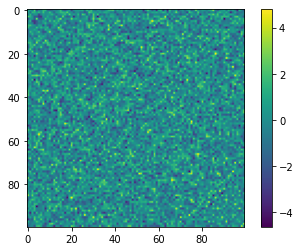

In [7]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [8]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [9]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [10]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [11]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

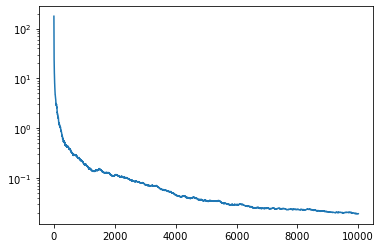

In [12]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [13]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [14]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [15]:
f(x0)

DeviceArray(0., dtype=float64)

In [16]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [17]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

0.21261906623840332
0.0985569953918457


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


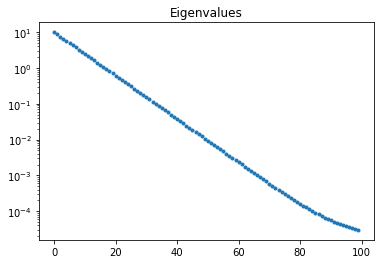

In [18]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [19]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 307.6658838445821
f(x_gt) = 92.87727801349784
gradF(x_gt) = [ 0.74442965 -0.76150356  0.60411152 -0.06204152  2.66565715 -0.17198185
 -7.62507127  2.75546632  4.16982031  2.94227284  2.78645606  0.17660401
 -5.30417481  6.16537025  0.89741703 -0.61447406 -3.23652571 -2.70912127
 -0.63873306 -3.13899299  2.70939547 -0.93600188  0.70194087  6.00776421
 -6.31447085 -0.75043511 -4.25250908 -3.88557869  4.27629779  3.33964779
 -4.61843804 -0.43191329 -2.61599684 -5.03408184 -0.0402148   0.54527115
 -2.04452507  4.74773153 -4.53818592  8.35025396  2.80374061  3.31872841
  0.26911251 -1.87344969 -2.08883547  2.69183614  4.33209073  1.15872109
  1.53761959 -1.19979752 -2.51522443 -0.16672988  2.69560027  4.30531174
 -6.707034   -4.94766762 -3.26938721  1.97237158  4.67511382 -7.46019385
  0.76965295  2.23369047  0.85560058  2.64765002  2.53680557 -4.38515641
  4.78136322  3.18896203 -1.6042946  -3.52887037  5.46530042 -0.21794064
 -2.03397586 -5.3960629  -0.74076495 -2.20812772 -

In [20]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [27]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 104.18739975766285
Iter 400: loss = 87.85956033201228
Iter 600: loss = 81.99645389326943
Iter 800: loss = 79.18245254472006
Iter 1000: loss = 77.53973291097147
Iter 1200: loss = 76.4411831059696
Iter 1400: loss = 75.62846809979166
Iter 1600: loss = 74.97897117688551
Iter 1800: loss = 74.42926768440118
Iter 2000: loss = 73.94467033778288
Iter 2200: loss = 73.505360513847
Iter 2400: loss = 73.0995381786208
Iter 2600: loss = 72.7198698288681
Iter 2800: loss = 72.36158518206108
Iter 3000: loss = 72.02143025709289
Iter 3200: loss = 71.69707749163945
Iter 3400: loss = 71.38678528682033
Iter 3600: loss = 71.08919652696679
Iter 3800: loss = 70.80321613860856
Iter 4000: loss = 70.52793455607403
Iter 4200: loss = 70.26257843920774
Iter 4400: loss = 70.0064779433544
Iter 4600: loss = 69.75904428638653
Iter 4800: loss = 69.51975388345099
Iter 5000: loss = 69.28813678053776
Iter 5200: loss = 69.06376797732338
Iter 5400: loss = 68.84626074452832
Iter 5600: loss = 68.63526135508684
I

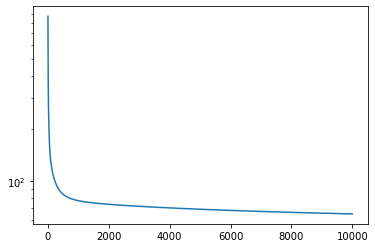

In [28]:
plt.semilogy(loss_gd)

In [29]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 51.819458115650654
Iter 2: loss = 51.81945811565069
Iter 3: loss = 51.81945811565074
Iter 4: loss = 51.819458115650704
Iter 5: loss = 51.8194581156506
Iter 6: loss = 51.819458115650654
Iter 7: loss = 51.81945811565066
Iter 8: loss = 51.81945811565072
Iter 9: loss = 51.819458115650704
Iter 10: loss = 51.81945811565068


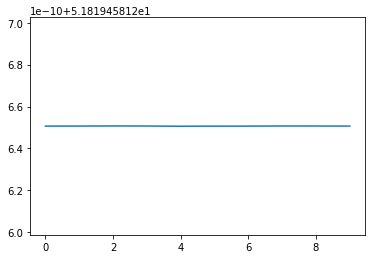

In [30]:
plt.plot(loss_n)

In [31]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 143.94660098464067
  cg iter 10 ||r|| = 5.277819693454843
  cg iter 20 ||r|| = 1.928908794230599
  cg iter 30 ||r|| = 1.1194615961354728
  cg iter 40 ||r|| = 1.3508236983846231
  cg iter 50 ||r|| = 0.919657817257842
  cg iter 60 ||r|| = 0.10440363014161458
  cg iter 70 ||r|| = 0.8326651115265415
  cg iter 80 ||r|| = 0.043842159202240834
  cg iter 90 ||r|| = 0.23758871015260546
  cg iter 100 ||r|| = 0.050978259132776226
  cg iter 110 ||r|| = 0.021688756390370056
  cg iter 120 ||r|| = 0.007027810904507705
  cg iter 130 ||r|| = 0.0022394463104909103
  cg iter 140 ||r|| = 0.0004872962906584043
  cg iter 150 ||r|| = 0.000317851966747198
  cg iter 160 ||r|| = 0.0016874991312879296
  cg iter 170 ||r|| = 0.00010651816996797169
  cg iter 180 ||r|| = 0.00020904869647089634
  cg iter 190 ||r|| = 2.0731389553055146e-05
  cg iter 200 ||r|| = 1.4181069521759911e-05
  cg iter 210 ||r|| = 0.0001254283628686466
  cg iter 220 ||r|| = 1.530236937503987e-05
  cg iter 230 ||r|| = 3.4130

In [32]:
F(x_cg)

DeviceArray(51.81945812, dtype=float64)

In [33]:
F(x_gd)

DeviceArray(65.16809811, dtype=float64)

In [34]:
F(x_n)

DeviceArray(51.81945812, dtype=float64)

#### OASIS

In [35]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [38]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 28826.82it/s]


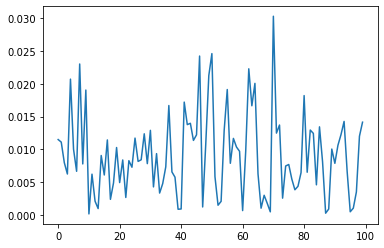

In [39]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [40]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 635.69it/s, loss=7.849e+01]

  Loss =  7.849e+01


Epoch 1000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.54it/s, loss=7.437e+01]

  Loss =  7.437e+01


Epoch 1500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.38it/s, loss=7.255e+01]

  Loss =  7.255e+01


Epoch 2000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 452.70it/s, loss=7.127e+01]

  Loss =  7.127e+01


Epoch 2500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 434.42it/s, loss=7.022e+01]

  Loss =  7.022e+01


Epoch 3000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 383.43it/s, loss=6.927e+01]

  Loss =  6.927e+01


Epoch 3500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 389.84it/s, loss=6.843e+01]

  Loss =  6.843e+01


Epoch 4000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 677.05it/s, loss=6.768e+01]

  Loss =  6.768e+01


Epoch 4500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.46it/s, loss=6.705e+01]

  Loss =  6.705e+01


Epoch 5000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 439.98it/s, loss=6.644e+01]

  Loss =  6.644e+01


Epoch 5500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 643.10it/s, loss=6.588e+01]

  Loss =  6.588e+01


Epoch 6000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.49it/s, loss=6.537e+01]

  Loss =  6.537e+01


Epoch 6500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 649.37it/s, loss=6.491e+01]

  Loss =  6.491e+01


Epoch 7000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 529.72it/s, loss=6.452e+01]

  Loss =  6.452e+01


Epoch 7500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 665.76it/s, loss=6.415e+01]

  Loss =  6.415e+01


Epoch 8000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 448.44it/s, loss=6.380e+01]

  Loss =  6.380e+01


Epoch 8500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.68it/s, loss=6.346e+01]

  Loss =  6.346e+01


Epoch 9000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.98it/s, loss=6.314e+01]

  Loss =  6.314e+01


Epoch 9500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 638.50it/s, loss=6.283e+01]

  Loss =  6.283e+01


Epoch 10000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 665.76it/s, loss=6.256e+01]

  Loss =  6.256e+01


In [41]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 521.36it/s, loss=6.487e+01]

  Loss =  6.487e+01


Epoch 1000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.60it/s, loss=6.085e+01]

  Loss =  6.085e+01


Epoch 1500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 479.62it/s, loss=5.889e+01]

  Loss =  5.889e+01


Epoch 2000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 487.09it/s, loss=5.765e+01]

  Loss =  5.765e+01


Epoch 2500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 464.69it/s, loss=5.677e+01]

  Loss =  5.677e+01


Epoch 3000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.18it/s, loss=5.608e+01]

  Loss =  5.608e+01


Epoch 3500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 495.37it/s, loss=5.554e+01]

  Loss =  5.554e+01


Epoch 4000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 408.64it/s, loss=5.509e+01]

  Loss =  5.509e+01


Epoch 4500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 386.96it/s, loss=5.472e+01]

  Loss =  5.472e+01


Epoch 5000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.59it/s, loss=5.446e+01]

  Loss =  5.446e+01


Epoch 5500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.04it/s, loss=5.421e+01]

  Loss =  5.421e+01


Epoch 6000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 401.79it/s, loss=5.397e+01]

  Loss =  5.397e+01


Epoch 6500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.03it/s, loss=5.377e+01]

  Loss =  5.377e+01


Epoch 7000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 368.18it/s, loss=5.362e+01]

  Loss =  5.362e+01


Epoch 7500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.01it/s, loss=5.349e+01]

  Loss =  5.349e+01


Epoch 8000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.27it/s, loss=5.335e+01]

  Loss =  5.335e+01


Epoch 8500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 536.49it/s, loss=5.325e+01]

  Loss =  5.325e+01


Epoch 9000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.59it/s, loss=5.315e+01]

  Loss =  5.315e+01


Epoch 9500/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.00it/s, loss=5.306e+01]

  Loss =  5.306e+01


Epoch 10000/10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 660.94it/s, loss=5.298e+01]

  Loss =  5.298e+01


4.809336138748592
4.809336138716828
1.1711438035497406
1.4678925938555498
3.5729200144301547


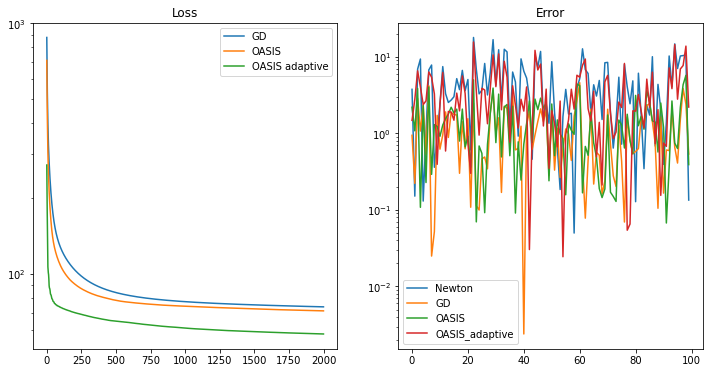

In [43]:
print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [44]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [45]:
sig_noise = 10
lam = 0.1

In [143]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [144]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 2.61e+08


In [145]:
jnp.max(w)

DeviceArray(1.00000001e+10, dtype=float64)

In [146]:
jnp.min(w)

DeviceArray(38.32889582, dtype=float64)

In [147]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [148]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

60.0602381613081
49.697019849732136
(100,)
(100,)
(100,)
(100,)


In [149]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [150]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(49.69701985, dtype=float64)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 979.63it/s]


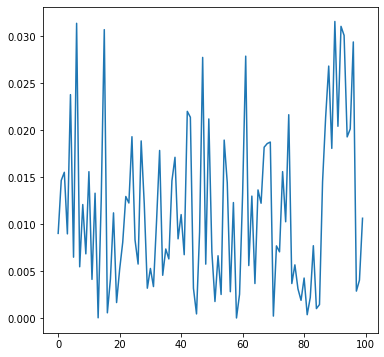

In [151]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [152]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.03it/s, loss=1.335e+15]


  Loss =  1.371e+17
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 434.13it/s, loss=2.436e+12]


  Loss =  1.372e+14
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 433.37it/s, loss=8.729e+09]


  Loss =  4.071e+11
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 431.15it/s, loss=2.328e+07]


  Loss =  1.203e+09
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.10it/s, loss=7.938e+04]


  Loss =  3.726e+06
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 429.46it/s, loss=3.536e+02]


  Loss =  1.143e+04
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 429.21it/s, loss=5.166e+01]


  Loss =  8.443e+01
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 447.75it/s, loss=4.789e+01]


  Loss =  4.948e+01
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 460.04it/s, loss=5.159e+01]


  Loss =  4.939e+01
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 452.24it/s, loss=5.077e+01]


  Loss =  4.939e+01
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.09it/s, loss=4.644e+01]


  Loss =  4.936e+01
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 444.71it/s, loss=5.162e+01]


  Loss =  4.937e+01
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.25it/s, loss=5.064e+01]


  Loss =  4.936e+01
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 456.17it/s, loss=4.962e+01]


  Loss =  4.938e+01
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.68it/s, loss=4.767e+01]


  Loss =  4.936e+01
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.24it/s, loss=4.803e+01]


  Loss =  4.939e+01
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.26it/s, loss=4.875e+01]


  Loss =  4.938e+01
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 452.00it/s, loss=4.766e+01]


  Loss =  4.936e+01
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.90it/s, loss=4.853e+01]


  Loss =  4.938e+01
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.05it/s, loss=4.810e+01]


  Loss =  4.937e+01


In [153]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 320.09it/s, loss=3.122e+15]

  Loss =  1.970e+17
Epoch 2/20



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 318.83it/s, loss=1.289e+13]


  Loss =  4.521e+14
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.35it/s, loss=6.423e+10]


  Loss =  1.946e+12
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 333.19it/s, loss=1.211e+08]


  Loss =  8.223e+09
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 319.95it/s, loss=3.724e+05]


  Loss =  1.510e+07
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 315.38it/s, loss=1.620e+03]


  Loss =  6.156e+04
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 326.61it/s, loss=5.734e+01]


  Loss =  2.869e+02
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 317.49it/s, loss=5.057e+01]


  Loss =  5.109e+01
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 323.29it/s, loss=4.756e+01]


  Loss =  4.945e+01
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 323.90it/s, loss=4.910e+01]


  Loss =  4.943e+01
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.30it/s, loss=4.801e+01]


  Loss =  4.947e+01
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.10it/s, loss=4.981e+01]


  Loss =  4.944e+01
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 339.04it/s, loss=4.907e+01]


  Loss =  4.943e+01
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 338.05it/s, loss=4.929e+01]


  Loss =  4.944e+01
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 340.53it/s, loss=5.000e+01]


  Loss =  4.946e+01
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 330.56it/s, loss=5.025e+01]


  Loss =  4.941e+01
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 317.51it/s, loss=4.950e+01]


  Loss =  4.943e+01
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 318.04it/s, loss=5.442e+01]


  Loss =  4.942e+01
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 315.87it/s, loss=4.722e+01]


  Loss =  4.941e+01
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.96it/s, loss=5.088e+01]


  Loss =  4.946e+01


In [156]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.92it/s, loss=1.315e+18]


  Loss =  1.315e+18
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s, loss=1.073e+18]


  Loss =  1.073e+18
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s, loss=8.817e+17]


  Loss =  8.817e+17
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s, loss=7.286e+17]


  Loss =  7.286e+17
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s, loss=6.050e+17]


  Loss =  6.050e+17
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s, loss=5.056e+17]


  Loss =  5.056e+17
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.21it/s, loss=4.240e+17]


  Loss =  4.240e+17
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.88it/s, loss=3.566e+17]


  Loss =  3.566e+17
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s, loss=3.007e+17]


  Loss =  3.007e+17
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.21it/s, loss=2.543e+17]


  Loss =  2.543e+17
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s, loss=2.154e+17]


  Loss =  2.154e+17
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.28it/s, loss=1.830e+17]


  Loss =  1.830e+17
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.55it/s, loss=1.558e+17]


  Loss =  1.558e+17
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.37it/s, loss=1.329e+17]


  Loss =  1.329e+17
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.35it/s, loss=1.136e+17]


  Loss =  1.136e+17
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.38it/s, loss=9.730e+16]


  Loss =  9.730e+16
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.92it/s, loss=8.345e+16]


  Loss =  8.345e+16
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.37it/s, loss=7.171e+16]


  Loss =  7.171e+16
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s, loss=6.173e+16]


  Loss =  6.173e+16
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.86it/s, loss=5.321e+16]

  Loss =  5.321e+16


In [157]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s, loss=9.272e+17]


  Loss =  9.272e+17
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s, loss=4.780e+17]


  Loss =  4.780e+17
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.79it/s, loss=3.123e+17]


  Loss =  3.123e+17
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s, loss=2.242e+17]


  Loss =  2.242e+17
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.91it/s, loss=2.066e+17]


  Loss =  2.066e+17
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.68it/s, loss=1.898e+17]


  Loss =  1.898e+17
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.90it/s, loss=1.679e+17]


  Loss =  1.679e+17
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.33it/s, loss=1.384e+17]


  Loss =  1.384e+17
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.78it/s, loss=1.010e+17]


  Loss =  1.010e+17
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.62it/s, loss=6.001e+16]


  Loss =  6.001e+16
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.16it/s, loss=2.494e+16]


  Loss =  2.494e+16
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.44it/s, loss=1.120e+16]


  Loss =  1.120e+16
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.06it/s, loss=1.239e+16]


  Loss =  1.239e+16
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.72it/s, loss=7.637e+15]


  Loss =  7.637e+15
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s, loss=6.447e+15]


  Loss =  6.447e+15
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s, loss=5.904e+15]


  Loss =  5.904e+15
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.67it/s, loss=5.462e+15]


  Loss =  5.462e+15
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s, loss=4.908e+15]


  Loss =  4.908e+15
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.13it/s, loss=4.140e+15]


  Loss =  4.140e+15
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.24it/s, loss=3.135e+15]

  Loss =  3.135e+15


In [181]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

Epoch 1/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.54it/s, grad=4.735e+16, loss=3.516e+17]


  |Grad| = 8.035e+16
  Loss = 8.399e+17
Epoch 2/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.95it/s, grad=2.155e+16, loss=5.907e+16]


  |Grad| = 3.271e+16
  Loss = 1.484e+17
Epoch 3/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 940.19it/s, grad=9.901e+15, loss=1.615e+16]


  |Grad| = 1.442e+16
  Loss = 3.296e+16
Epoch 4/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 931.43it/s, grad=5.568e+15, loss=3.654e+15]


  |Grad| = 7.372e+15
  Loss = 8.245e+15
Epoch 5/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.53it/s, grad=3.119e+15, loss=1.106e+15]


  |Grad| = 3.843e+15
  Loss = 2.222e+15
Epoch 6/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.61it/s, grad=1.870e+15, loss=3.615e+14]


  |Grad| = 1.940e+15
  Loss = 6.271e+14
Epoch 7/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.13it/s, grad=8.615e+14, loss=1.162e+14]


  |Grad| = 1.039e+15
  Loss = 1.817e+14
Epoch 8/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.61it/s, grad=4.993e+14, loss=2.987e+13]


  |Grad| = 5.814e+14
  Loss = 5.378e+13
Epoch 9/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 784.24it/s, grad=2.918e+14, loss=7.544e+12]


  |Grad| = 3.075e+14
  Loss = 1.616e+13
Epoch 10/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 837.69it/s, grad=7.746e+13, loss=2.277e+12]


  |Grad| = 1.688e+14
  Loss = 4.922e+12
Epoch 11/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.28it/s, grad=4.118e+13, loss=6.102e+11]


  |Grad| = 9.026e+13
  Loss = 1.515e+12
Epoch 12/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.14it/s, grad=4.264e+13, loss=2.751e+11]


  |Grad| = 5.068e+13
  Loss = 4.691e+11
Epoch 13/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.54it/s, grad=2.637e+13, loss=8.745e+10]


  |Grad| = 2.976e+13
  Loss = 1.462e+11
Epoch 14/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 824.39it/s, grad=1.378e+13, loss=2.297e+10]


  |Grad| = 1.621e+13
  Loss = 4.608e+10
Epoch 15/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 880.58it/s, grad=5.750e+12, loss=7.252e+09]


  |Grad| = 9.248e+12
  Loss = 1.456e+10
Epoch 16/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.07it/s, grad=4.004e+12, loss=2.238e+09]


  |Grad| = 5.029e+12
  Loss = 4.613e+09
Epoch 17/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.32it/s, grad=2.286e+12, loss=8.870e+08]


  |Grad| = 2.844e+12
  Loss = 1.469e+09
Epoch 18/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 849.96it/s, grad=1.097e+12, loss=2.432e+08]

  |Grad| = 1.670e+12


  Loss = 4.708e+08
Epoch 19/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 844.24it/s, grad=6.393e+11, loss=7.445e+07]


  |Grad| = 9.178e+11
  Loss = 1.507e+08
Epoch 20/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.66it/s, grad=4.790e+11, loss=2.849e+07]


  |Grad| = 5.167e+11
  Loss = 4.876e+07


In [182]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

Epoch 1/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 753.92it/s, grad=3.475e+15, loss=8.530e+14]


  |Grad| = 3.135e+16
  Loss = 1.598e+17
Epoch 2/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 799.04it/s, grad=1.059e+14, loss=1.252e+12]


  |Grad| = 7.717e+14
  Loss = 1.061e+14
Epoch 3/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 798.97it/s, grad=5.103e+12, loss=2.436e+09]


  |Grad| = 3.324e+13
  Loss = 1.989e+11
Epoch 4/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.29it/s, grad=2.876e+11, loss=9.846e+06]


  |Grad| = 1.527e+12
  Loss = 4.588e+08
Epoch 5/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.43it/s, grad=1.321e+10, loss=3.072e+04]


  |Grad| = 9.008e+10
  Loss = 1.287e+06
Epoch 6/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 814.20it/s, grad=9.193e+08, loss=1.146e+02]


  |Grad| = 4.500e+09
  Loss = 3.844e+03
Epoch 7/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.53it/s, grad=1.183e+08, loss=4.885e+01]


  |Grad| = 2.879e+08
  Loss = 6.118e+01
Epoch 8/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 784.04it/s, grad=1.137e+08, loss=4.784e+01]


  |Grad| = 9.859e+07
  Loss = 4.941e+01
Epoch 9/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 776.65it/s, grad=8.077e+07, loss=4.892e+01]


  |Grad| = 9.477e+07
  Loss = 4.937e+01
Epoch 10/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 804.92it/s, grad=1.026e+08, loss=4.782e+01]


  |Grad| = 9.933e+07
  Loss = 4.937e+01
Epoch 11/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.38it/s, grad=9.430e+07, loss=4.906e+01]


  |Grad| = 9.830e+07
  Loss = 4.937e+01
Epoch 12/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 788.47it/s, grad=1.004e+08, loss=4.865e+01]


  |Grad| = 9.809e+07
  Loss = 4.936e+01
Epoch 13/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.58it/s, grad=1.469e+08, loss=4.913e+01]


  |Grad| = 1.050e+08
  Loss = 4.938e+01
Epoch 14/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 809.32it/s, grad=1.126e+08, loss=5.034e+01]


  |Grad| = 9.953e+07
  Loss = 4.938e+01
Epoch 15/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 825.03it/s, grad=1.173e+08, loss=4.903e+01]


  |Grad| = 9.926e+07
  Loss = 4.939e+01
Epoch 16/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 800.38it/s, grad=1.260e+08, loss=4.920e+01]


  |Grad| = 9.919e+07
  Loss = 4.936e+01
Epoch 17/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 802.31it/s, grad=7.363e+07, loss=5.043e+01]


  |Grad| = 9.906e+07
  Loss = 4.937e+01
Epoch 18/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.52it/s, grad=7.398e+07, loss=5.038e+01]


  |Grad| = 1.002e+08
  Loss = 4.938e+01
Epoch 19/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 816.12it/s, grad=8.259e+07, loss=4.749e+01]


  |Grad| = 9.503e+07
  Loss = 4.937e+01
Epoch 20/20 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.52it/s, grad=7.211e+07, loss=5.098e+01]


  |Grad| = 9.587e+07
  Loss = 4.939e+01


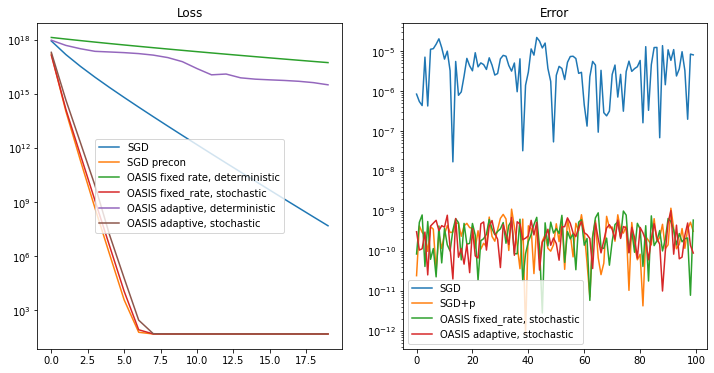

In [183]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

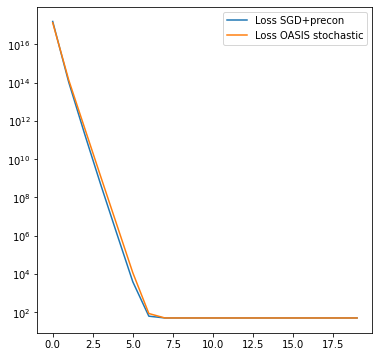

In [184]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [172]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


49.697019849732136
nan
49.84225517637248
5.321281466308749e+16
49.71939650431524
3135003841836942.5
49.69827579674441


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~